<a href="https://colab.research.google.com/github/thimotyb/real-world-machine-learning/blob/python3/Forest%2C_Features_and_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dimostrazione di valutazione dell'importanza delle feature selezionate nella foresta
## Confronto tra classificazione ad albero singolo, random forest e LightGBM


Import SciKit Tree Library and LightGBM Library

In [0]:
from sklearn import tree
import pandas
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb # Microsoft lightGBM install with: conda install -c conda-forge lightgbm

My functions to do OHE and do feature engineering on Titanic

In [0]:
def cat_to_num(data):
    categories = np.unique(data)
    features = {}
    for cat in categories:
        binary = (data == cat)
        features["%s=%s" % (data.name, cat)] = binary.astype("int")
    return pandas.DataFrame(features)
    
def prepare_data(data):
    """Takes a dataframe of raw data and returns ML model features
    """
    
    # Initially, we build a model only on the available numerical values
    features = data.drop(["PassengerId", "Survived", "Fare", "Name", "Sex", "Ticket", "Cabin", "Embarked"], axis=1)
    
    # Setting missing age values to -1
    features["Age"] = data["Age"].fillna(-1)
    
    # Adding the sqrt of the fare feature
    features["sqrt_Fare"] = np.sqrt(data["Fare"])
    
    # Adding gender categorical value
    features = features.join( cat_to_num(data['Sex']) )
    
    # Adding Embarked categorical value
    features = features.join( cat_to_num(data['Embarked'].fillna("")) )
    
    return features


Load, split, prepare data

In [0]:
data = pandas.read_csv("https://raw.githubusercontent.com/thimotyb/real-world-machine-learning/master/data/titanic.csv")
data_train = data[:int(0.8*len(data))]
data_test = data[int(0.8*len(data)):]
features = prepare_data(data_train)

## First Model: Using a Single Tree Classifier

In [56]:
model = tree.DecisionTreeClassifier(max_depth = 4)
model.fit(features, data_train["Survived"])
print(model.score(prepare_data(data_train), data_train["Survived"]))
model.score(prepare_data(data_test), data_test["Survived"])

0.8117977528089888


0.8212290502793296

## Second Model: Using a Random Forest

In [57]:
from sklearn import ensemble # RF is an ensemble category of model
forest = ensemble.RandomForestClassifier(n_estimators=10, bootstrap=False, max_features="auto")
forest.fit(features, data_train["Survived"])
print(forest.score(prepare_data(data_train), data_train["Survived"]))
forest.score(prepare_data(data_test), data_test["Survived"])

0.9817415730337079


0.8100558659217877

Feature importance in the Random Forest

In [0]:
# Elenca e visualizza il ranking delle feature usate nelal foresta
def show_features(forest, X, y):
  importances = forest.feature_importances_

  # Calcola deviazione standard per plottare errore
  std = np.std([tree.feature_importances_ for tree in forest.estimators_],
              axis=0)
  indices = np.argsort(importances)[::-1]

  # Print the feature ranking
  print("Feature ranking:")

  for f in range(X.shape[1]):
      print("%d. feature %s (%f)" % (indices[f], features.columns[indices[f]], importances[indices[f]]))

  # Plot the feature importances of the forest
  plt.figure()
  plt.title("Feature importances")
  plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
  plt.xticks(range(X.shape[1]), indices)
  plt.xlim([-1, X.shape[1]])
  plt.show()
  

Feature ranking:
4. feature sqrt_Fare (0.265602)
1. feature Age (0.247583)
5. feature Sex=female (0.185947)
6. feature Sex=male (0.103359)
0. feature Pclass (0.088492)
2. feature SibSp (0.048041)
3. feature Parch (0.033908)
10. feature Embarked=S (0.011953)
8. feature Embarked=C (0.008131)
9. feature Embarked=Q (0.006984)
7. feature Embarked= (0.000000)


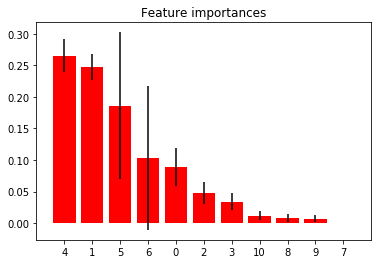

In [59]:
show_features(forest, features, data_train["Survived"])

Mostra gli Stimatori che sono stati usati per comporre la foresta

In [60]:
len(forest.estimators_) # Questo coincide con il numero di stimatori prodotti per popolare la foresta

10

## Classificazione con una foresta più grande

In [61]:
extraforest = ensemble.ExtraTreesClassifier(n_estimators=100, bootstrap=True)
extraforest.fit(features, data_train["Survived"])
print(extraforest.score(prepare_data(data_train), data_train["Survived"]))
extraforest.score(prepare_data(data_test), data_test["Survived"])

0.9803370786516854


0.8100558659217877

Feature ranking:
4. feature sqrt_Fare (0.237942)
1. feature Age (0.225939)
5. feature Sex=female (0.154721)
6. feature Sex=male (0.138528)
0. feature Pclass (0.101043)
2. feature SibSp (0.055000)
3. feature Parch (0.049342)
10. feature Embarked=S (0.016581)
8. feature Embarked=C (0.013136)
9. feature Embarked=Q (0.007683)
7. feature Embarked= (0.000085)


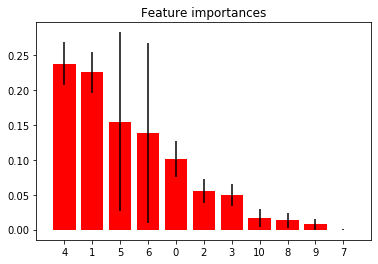

In [62]:
show_features(extraforest, features, data_train["Survived"])

## Classificazione con LightGBM

In [0]:
d_train = lgb.Dataset(features, label=data_train["Survived"])
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10
light_gbm = lgb.train(params, d_train, 100)

In [66]:
#Prediction
y_pred=light_gbm.predict(data_test)
#convert into binary values
for i in range(0,99):
    if y_pred[i]>=.5:       # setting threshold to .5
       y_pred[i]=1
    else:  
       y_pred[i]=0

ValueError: ignored

In [67]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(data_test, y_pred)
#Accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred,data_test)

NameError: ignored